In [1]:
import networkx as nx
%matplotlib inline

# Chapter 2 Tutorial

Note that many exercises are followed by a block with some `assert` statements. These assertions may be preceded by some setup code. They are provided to give you feedback that you are on the right path -- receiving an `AssertionError` probably means you've done something wrong.

Contents:

1. Paths
2. Connected components
3. Directed paths & components
4. Dataset: US air traffic network

<h1> Assortativity </h1>

degree assortativity / correlation = high-degree nodes tend to be connected to other high-degree nodes. Networks with such property have a core-periphery structure.

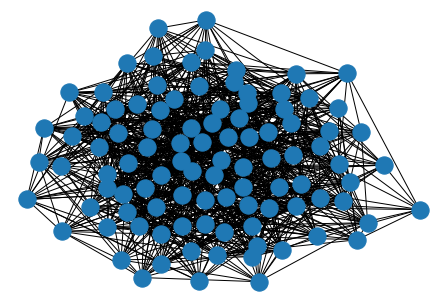

In [4]:
G = nx.erdos_renyi_graph(100, 0.2)
nx.draw(G)

In [ ]:
# correlation based on categorical features
# nx.attribute_assortativity_coefficient(G, category)

# correlation based on numeric features
# nx.numeric_assortativity_coefficient(G, quantity)

In [5]:
# pearson correlation between degree of pairs of linked nodes
nx.degree_assortativity_coefficient(G)

-0.0016014224482791572

In [8]:
# measure average degree of neighbors of node i
import scipy.stats
# average(neighbors' degrees)
knn_dict = nx.k_nearest_neighbors(G)
k, knn = list(knn_dict.keys()), list(knn_dict.values())
scipy.stats.pearsonr(k, knn)

(0.3072597169207293, 0.21487175052620747)

# 1. Paths

Let's start with a very simple, undirected network.

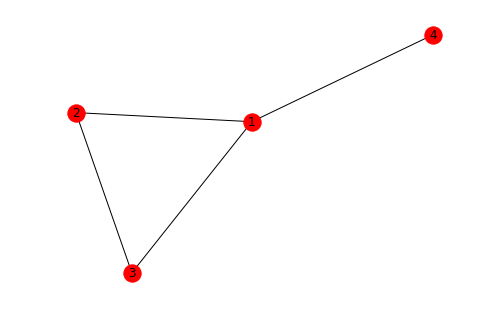

In [2]:
G = nx.Graph()

G.add_nodes_from([1,2,3,4])

G.add_edges_from([(1,2),(2,3),(1,3),(1,4)])

nx.draw(G, with_labels=True)

A *path* in a network is a sequence of edges connecting two nodes. In this simple example, we can easily see that there is indeed at least one path that connects nodes 3 and 4. We can verify this with NetworkX:

In [3]:
nx.has_path(G, 3, 4)

True

There can be more than one path between two nodes. Again considering nodes 3 and 4, there are two such "simple" paths:

In [4]:
list(nx.all_simple_paths(G, 3, 4))

[[3, 2, 1, 4], [3, 1, 4]]

A simple path is one without any cycles. If we allowed cycles, there would be infinitely many paths because one could always just go around the cycle as many times as desired.

We are often most interested in *shortest* paths. In an unweighted network, the shortest path is the one with the fewest edges. We can see that of the two simple paths between nodes 3 and 4, one is shorter than the other. We can get this shortest path with a single NetworkX function:

In [5]:
nx.shortest_path(G, 3, 4)

[3, 1, 4]

If you only care about the path length, there's a function for that too:

In [6]:
nx.shortest_path_length(G, 3, 4)

2

Note that a path length is defined here by the number of *edges* in the path, not the number of nodes, which implies

    nx.shortest_path_length(G, u, v) == len(nx.shortest_path(G, u, v)) - 1
    
for nodes $u$ and $v$.

## 2. Connected components

In the simple network above, we can see that for *every* pair of nodes, we can find a path connecting them. This is the definition of a *connected* graph. We can check this property for a given graph:

In [7]:
nx.is_connected(G)

True

Not every graph is connected:

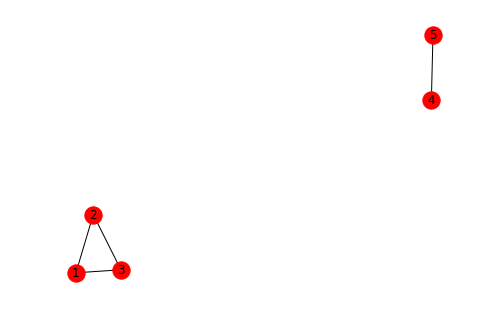

In [8]:
G = nx.Graph()

G.add_cycle((1,2,3))
G.add_edge(4,5)

nx.draw(G, with_labels=True)

In [9]:
nx.is_connected(G)

False

And NetworkX will raise an error if you ask for a path between nodes where none exists:

In [10]:
nx.has_path(G, 3, 5)

False

In [11]:
nx.shortest_path(G, 3, 5)

NetworkXNoPath: No path between 3 and 5.

Visually, we can identify two connected components in our graph. Let's verify this:

In [12]:
nx.number_connected_components(G)

2

The `nx.connected_components()` function takes a graph and returns a list of sets of node names, one such set for each connected component. Verify that the two sets in the following list correspond to the two connected components in the drawing of the graph above:

In [13]:
list(nx.connected_components(G))

[{1, 2, 3}, {4, 5}]

In case you're not familiar with Python sets, they are collections of items without duplicates. These are useful for collecting node names because node names should be unique. As with other collections, we can get the number of items in a set with the `len` function:

In [14]:
components = list(nx.connected_components(G))
len(components[0])

3

We often care about the largest connected component, which is sometimes referred to as the *core* of the network. We can make use of Python's builtin `max` function in order to obtain the largest connected component. By default, Python's `max` function sorts things in lexicographic (i.e. alphabetical) order, which is not helpful here. We want the maximum connected component when sorted in order of their sizes, so we pass `len` as a key function:

In [15]:
max(nx.connected_components(G), key=len)

{1, 2, 3}

While it's often enough to just have the list of node names, sometimes we need the actual subgraph consisting of the largest connected component. One way to get this is to pass the list of node names to the `G.subgraph()` function:

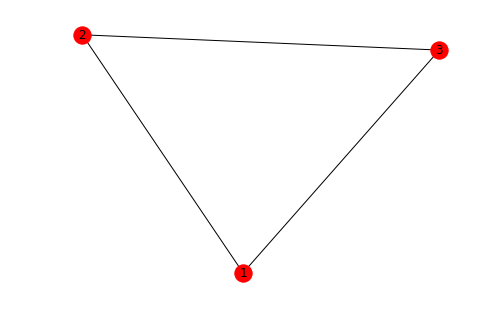

In [16]:
core_nodes = max(nx.connected_components(G), key=len)
core = G.subgraph(core_nodes)

nx.draw(core, with_labels=True)

Those of you using tab-completion will also notice a `nx.connected_component_subgraphs()` function. This can also be used to get the core subgraph but the method shown is more efficient when you only care about the largest connected component.

# 3. Directed paths & components

Let's extend these ideas about paths and connected components to directed graphs.

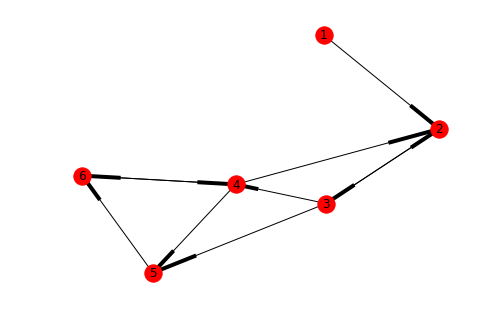

In [17]:
D = nx.DiGraph()
D.add_edges_from([
    (1,2),
    (2,3),
    (3,2), (3,4), (3,5),
    (4,2), (4,5), (4,6),
    (5,6),
    (6,4),
])
nx.draw(D, with_labels=True)

### Directed paths

We know that in a directed graph, an edge from an arbitrary node $u$ to an arbitrary node $v$ does not imply that an edge exists from $v$ to $u$. Since paths must follow edge direction in directed graphs, the same asymmetry applies for paths. Observe that this graph has a path from 1 to 4, but not in the reverse direction.

In [18]:
nx.has_path(D, 1, 4)

True

In [19]:
nx.has_path(D, 4, 1)

False

The other NetworkX functions dealing with paths take this asymmetry into account as well:

In [20]:
nx.shortest_path(D, 2, 5)

[2, 3, 5]

In [21]:
nx.shortest_path(D, 5, 2)

[5, 6, 4, 2]

Since there is no edge from 5 to 3, the shortest path from 5 to 2 cannot simply backtrack the shortest path from 2 to 5 -- it has to go a longer route through nodes 6 and 4.

### Directed components

Directed networks have two kinds of connectivity. *Strongly connected* means that there exists a directed path between every pair of nodes, i.e., that from any node we can get to any other node while following edge directionality. Think of cars on a network of one-way streets: they can't drive against the flow of traffic.

In [22]:
nx.is_strongly_connected(D)

False

*Weakly connected* means that there exist a path between every pair of nodes, regardless of direction. Think about pedestrians on a network of one-way streets: they walk on the sidewalks so they don't care about the direction of traffic.

In [23]:
nx.is_weakly_connected(D)

True

If a network is strongly connected, it is also weakly connected. The converse is not always true, as seen in this example.

The `is_connected` function for undirected graphs will raise an error when given a directed graph.

In [24]:
# This will raise an error
nx.is_connected(D)

NetworkXNotImplemented: not implemented for directed type

In the directed case, instead of `nx.connected_components` we now have `nx.weakly_connected_components` and `nx.strongly_connected_components`:

In [25]:
list(nx.weakly_connected_components(D))

[{1, 2, 3, 4, 5, 6}]

In [26]:
list(nx.strongly_connected_components(D))

[{2, 3, 4, 5, 6}, {1}]

## 4. Dataset: US air traffic network

This repository contains several example network datasets. Among these is a network of US air travel routes:

In [27]:
G = nx.read_graphml('../datasets/openflights/openflights_usa.graphml.gz')

The nodes in this graph are airports, represented by their [IATA codes](https://en.wikipedia.org/wiki/List_of_airports_by_IATA_code:_A); two nodes are connected with an edge if there is a scheduled flight directly connecting these two airports. We'll assume this graph to be undirected since a flight in one direction usually means there is a return flight.

Thus this graph has edges
```
[('HOM', 'ANC'), ('BGM', 'PHL'), ('BGM', 'IAD'), ...]
```
where ANC is Anchorage, IAD is Washington Dulles, etc.

These nodes also have **attributes** associated with them, containing additional information about the airports:

In [28]:
G.nodes['IND']

{'IATA': 'IND',
 'latitude': 39.7173,
 'longitude': -86.294403,
 'name': 'Indianapolis International Airport'}

Node attributes are stored as a dictionary, so the values can be accessed individually as such:

In [29]:
G.nodes['IND']['name']

'Indianapolis International Airport'

# EXERCISE 1

Is there a direct flight between Indianapolis and Fairbanks, Alaska (FAI)? A direct flight is one with no intermediate stops.

# EXERCISE 2

If I wanted to fly from Indianapolis to Fairbanks, Alaska what would be an itinerary with the fewest number of flights?

# EXERCISE 3

Is it possible to travel from any airport in the US to any other airport in the US, possibly using connecting flights? In other words, does there exist a path in the network between every possible pair of airports?